<a href="https://colab.research.google.com/github/ashish42/MachineLearningPython/blob/master/Customer_Life_Time_Value_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Customer Life time value in retail**

In this script we will be working on open sourced dataset from UCI

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")


df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


##Data Cleaning 

In [2]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
print(df.head())
print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


##The following analysis is conducted in Python using Lifetimes packagedeveloped by Cameron Davidson-Pilon, data scientist at Shopify, and the code was largely borrowed from [lifetime documenation](https://lifetimes.readthedocs.io/)


In [6]:
!pip install lifetimes

In [0]:
import lifetimes

In [9]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


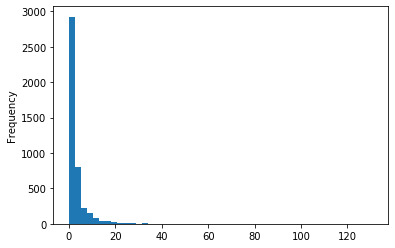

In [13]:
data['frequency'].plot(kind='hist', bins=50)

In [14]:
print(data['frequency'].describe())

count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64


In [15]:
print(sum(data['frequency'] == 0)/float(len(data))) 
#35% Customers are single transactors 

0.3569946992394561


In [19]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


##Visualizing our frequency/recency matrix

Consider: a customer has made purchase every day for four weeks straight, and then we haven’t heard from him in months. What are the chances he is still “alive”? Pretty small, right? On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his recency (age at last purchase) and frequency (the number of repeat transactions he has made).

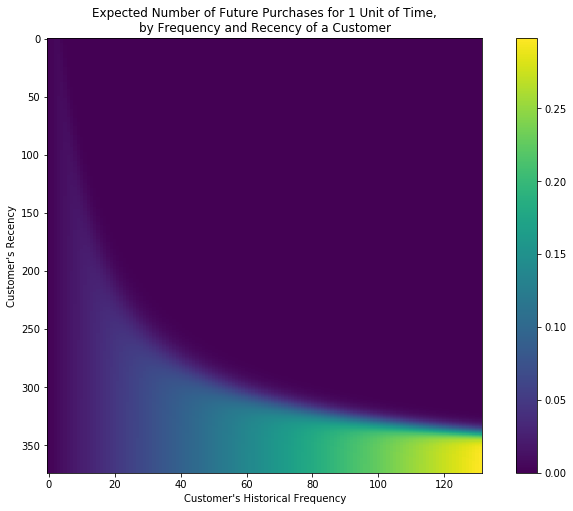

In [20]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

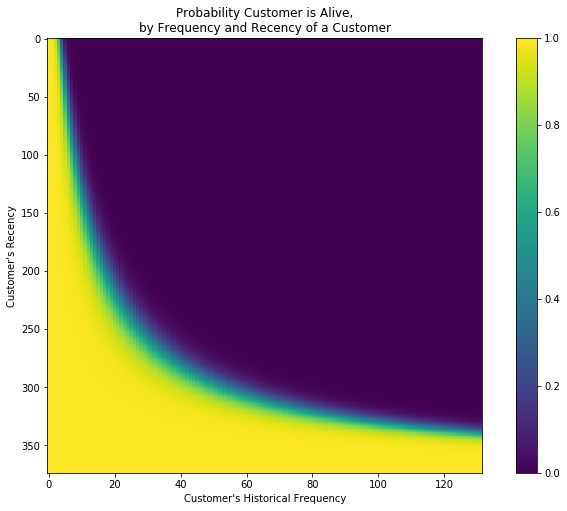

In [21]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [22]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.201005
15311.0,89.0,373.0,373.0,677.729438,0.203269
17841.0,111.0,372.0,373.0,364.452162,0.253053
12748.0,113.0,373.0,373.0,298.360885,0.257581
14911.0,131.0,372.0,373.0,1093.661679,0.298312


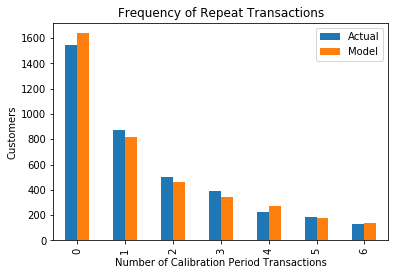

In [23]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [24]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  ...  frequency_holdout  duration_holdout
CustomerID                              ...                                     
12346.0               0.0          0.0  ...                0.0               184
12347.0               2.0        121.0  ...                4.0               184
12348.0               2.0        110.0  ...                1.0               184
12350.0               0.0          0.0  ...                0.0               184
12352.0               3.0         34.0  ...                3.0               184

[5 rows x 5 columns]


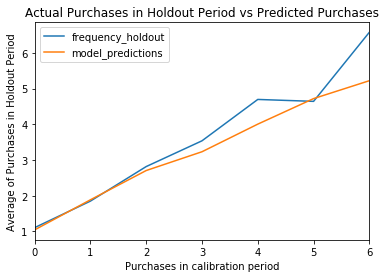

In [25]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [27]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.15727742663038222

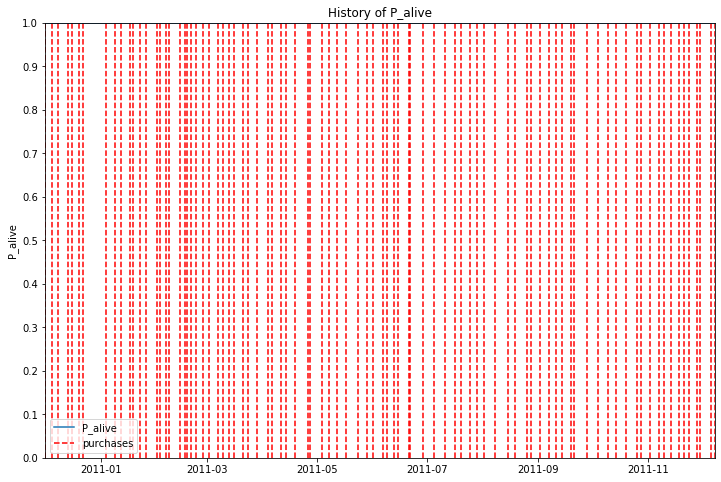

In [28]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

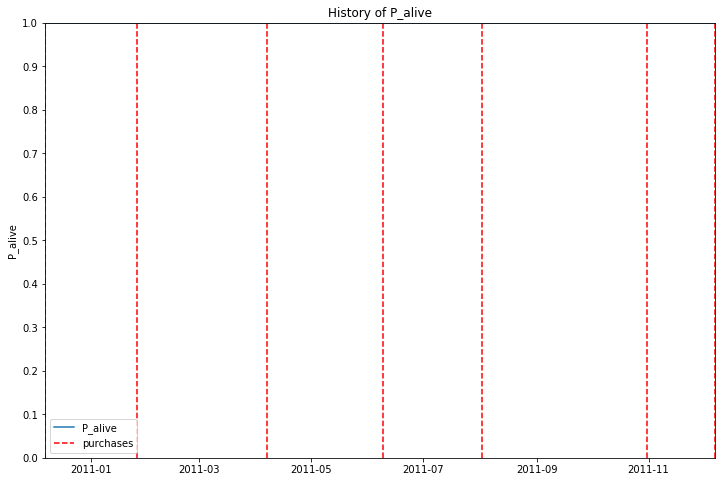

In [37]:
fig = plt.figure(figsize=(12,8) )
id = 12347
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

##Estimating customer lifetime value using gamma-gamma model of monetary value
We are now taking into account the economic value of each transaction. To estimate this we use the Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton, to predict likely spend per transaction in the future at the customer level.
We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 2,790 customers.

In [31]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.015656
12348.0           3.0    283.0  358.0      301.480000             0.008956
12352.0           6.0    260.0  296.0      368.256667             0.018697
12356.0           2.0    303.0  325.0      269.905000             0.007172
12358.0           1.0    149.0  150.0      683.200000             0.008340
2790


In [32]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [33]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64
